Some optimisation examples.

Date Created: 22 Apr 2018
<br>
Last Modified: 27 Apr 2018
<br>
Humans Responsible: The Prickly Pythons

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import time

import matplotlib as mpl
font_size = 16
mpl.rcParams['xtick.labelsize'] = font_size
mpl.rcParams['ytick.labelsize'] = font_size

# The Hungarian Algorithm

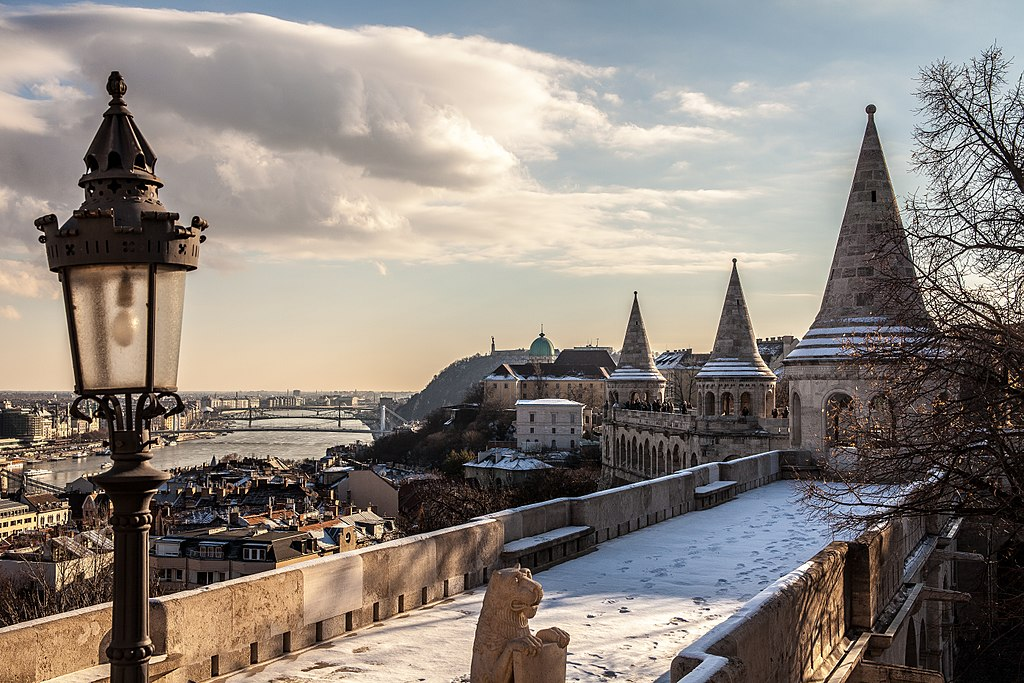

In [3]:
Image(filename='images/buda.jpg', width=700)
# Reference: https://en.wikipedia.org/wiki/Budapest

In [4]:
from scipy.optimize import linear_sum_assignment

In [5]:
cost = np.array([[300, 400, 400], 
                 [400, 600, 300], 
                 [200, 400, 300]])
cost

array([[300, 400, 400],
       [400, 600, 300],
       [200, 400, 300]])

In [6]:
row_ind, col_ind = linear_sum_assignment(cost)

col_ind

array([1, 2, 0])

In [8]:
# Minimum total cost
np.sum(cost[row_ind, col_ind])

900

# Sudoku

In [11]:
N_symbols = 9

N_constraints = 4

# Known entries
g = np.array([[1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9],
              [1, 2, 5, 1, 4, 5, 6, 2, 3, 8, 1, 5, 9, 1, 4, 6, 9, 1, 5, 9, 2, 7, 8, 4, 5, 6, 9, 5, 8, 9],
              [5, 3, 7, 6, 1, 9, 5, 9, 8, 6, 8, 6, 3, 4, 8, 3, 1, 7, 2, 6, 6, 2, 8, 4, 1, 9, 5, 8, 7, 9]])
g = g - 1 # Python indices start at 0

N_known = np.max(g.shape)

# Solution
x_true_sudoku = np.array([[5,3,4,6,7,8,9,1,2], 
                          [6,7,2,1,9,5,3,4,8], 
                          [1,9,8,3,4,2,5,6,7],
                          [8,5,9,7,6,1,4,2,3],
                          [4,2,6,8,5,3,7,9,1],
                          [7,1,3,9,2,4,8,5,6],
                          [9,6,1,5,3,7,2,8,4],
                          [2,8,7,4,1,9,6,3,5],
                          [3,4,5,2,8,6,1,7,9]])

In [12]:
x_true_sudoku

array([[5, 3, 4, 6, 7, 8, 9, 1, 2],
       [6, 7, 2, 1, 9, 5, 3, 4, 8],
       [1, 9, 8, 3, 4, 2, 5, 6, 7],
       [8, 5, 9, 7, 6, 1, 4, 2, 3],
       [4, 2, 6, 8, 5, 3, 7, 9, 1],
       [7, 1, 3, 9, 2, 4, 8, 5, 6],
       [9, 6, 1, 5, 3, 7, 2, 8, 4],
       [2, 8, 7, 4, 1, 9, 6, 3, 5],
       [3, 4, 5, 2, 8, 6, 1, 7, 9]])

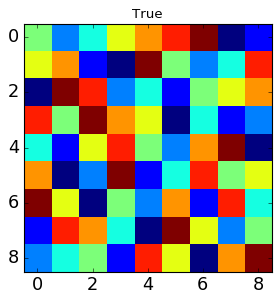

In [13]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
im = ax.imshow(x_true_sudoku, interpolation='nearest')
ax.set_title("True")
plt.show()

In [14]:
# Define the projection operators

def P_row(x):
    for i in range(N_symbols):
        cost = -x[i,:,:]
        row_ind, col_ind = linear_sum_assignment(cost)

        x[i,:,:] = 0
        for j in range(N_symbols):
            x[i,j,col_ind[j]] = 1

    return x


def P_col(x):
    for i in range(N_symbols):
        cost = -x[:,i,:]
        row_ind, col_ind = linear_sum_assignment(cost)

        x[:,i,:] = 0
        for j in range(N_symbols):
            x[j,i,col_ind[j]] = 1

    return x


def P_blo(x):
    for i in range(3):
        for j in range(3):
            cost = -x[i*3:(i+1)*3, j*3:(j+1)*3, :]
            cost = cost.reshape(N_symbols,N_symbols)
            row_ind, col_ind = linear_sum_assignment(cost)

            x[i*3:(i+1)*3, j*3:(j+1)*3, :] = 0
            ind = 0
            for k in range(i*3,(i+1)*3):
                for l in range(j*3,(j+1)*3):
                    x[k,l,col_ind[ind]] = 1
                    ind = ind + 1

    return x


def P_sym(x):
    ind = np.argmax(x, axis=2)

    x = np.zeros([N_symbols,N_symbols,N_symbols])
    for i in range(N_symbols):
        for j in range(N_symbols):
            x[i,j,ind[i,j]] = 1

    return x


def P_fix(x):
    # Assign known cells
    for i in range(N_known):
        x[g[0,i], g[1,i], g[2,i]] = 100

    return x


def return_sudoku(x):
    sudoku = np.zeros([N_symbols,N_symbols])
    for i in range(N_symbols):
        for j in range(N_symbols):
            sudoku[i,j] = np.argmax(x[i,j,:])

    return (sudoku + 1)

In [15]:
def P_A(x):
    x0 = P_row(x[0])

    x1 = P_col(x[1])

    x2 = P_blo(x[2])

    x3 = P_sym(x[3])

    x_new = [x0, x1, x2, x3]

    return x_new

def P_B(x):
    x_mean = (x[0] + x[1] + x[2] + x[3])/N_constraints

    x_mean = P_fix(x_mean)

    x_new = [x_mean, x_mean, x_mean, x_mean]

    return x_new

In [16]:
def R_A(x, gamma_A):
    PA = P_A(x)

    x_new = [0 for i in range(N_constraints)]
    for i in range(N_constraints):
        x_new[i] = (1 + gamma_A)*PA[i] - gamma_A*x[i]

    return x_new

def R_B(x, gamma_B):
    PB = P_B(x)

    x_new = [0 for i in range(N_constraints)]
    for i in range(N_constraints):
        x_new[i] = (1 + gamma_B)*PB[i] - gamma_B*x[i]

    return x_new

In [17]:
def DM(x, beta, gamma_A, gamma_B):
    x_PA = P_A(R_B(x, gamma_B))
    x_PB = P_B(R_A(x, gamma_A))

    x_new = [0 for i in range(N_constraints)]
    for i in range(N_constraints):
        x_new[i] = x[i] + beta*(x_PA[i] - x_PB[i])

    return x_new, x_PB[0]

<IPython.core.display.Javascript object>


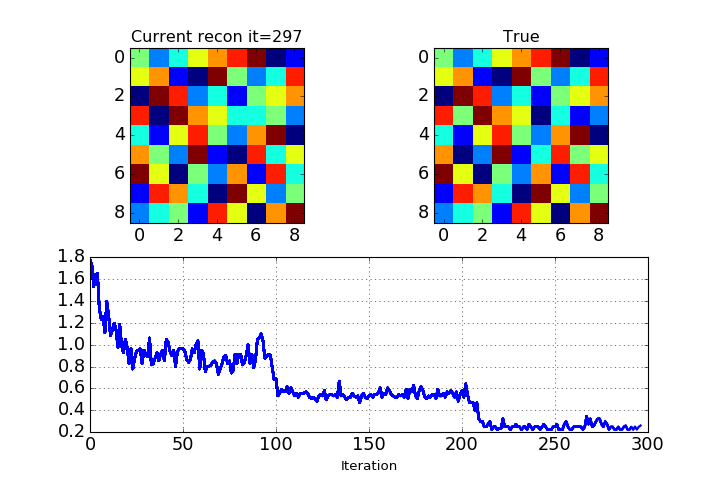

[[ 5.  3.  4.  6.  7.  8.  9.  1.  2.]
 [ 6.  7.  2.  1.  9.  5.  3.  4.  8.]
 [ 1.  9.  8.  3.  4.  2.  5.  6.  7.]
 [ 8.  1.  9.  7.  6.  4.  2.  5.  3.]
 [ 4.  2.  6.  8.  5.  3.  7.  9.  1.]
 [ 7.  5.  3.  9.  2.  1.  8.  4.  6.]
 [ 9.  6.  1.  5.  3.  7.  2.  8.  4.]
 [ 2.  8.  7.  4.  1.  9.  6.  3.  5.]
 [ 3.  4.  5.  2.  8.  6.  1.  7.  9.]]
[[5 3 4 6 7 8 9 1 2]
 [6 7 2 1 9 5 3 4 8]
 [1 9 8 3 4 2 5 6 7]
 [8 5 9 7 6 1 4 2 3]
 [4 2 6 8 5 3 7 9 1]
 [7 1 3 9 2 4 8 5 6]
 [9 6 1 5 3 7 2 8 4]
 [2 8 7 4 1 9 6 3 5]
 [3 4 5 2 8 6 1 7 9]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  4.  0.  0.  0. -3.  2. -3.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -4.  0.  0.  0.  3.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [18]:
%matplotlib notebook

it_max = 300

beta = 1.3 # Magic number
gamma_A = -1/beta
gamma_B = 1/beta

# Initial iterate
x = [np.random.rand(N_symbols,N_symbols,N_symbols) for n in range(N_constraints)] 


e_vec = np.zeros(it_max)

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(222)
im = ax.imshow(x_true_sudoku, interpolation='nearest')
ax.set_title("True")

for it in range(it_max):
    
    # Update rule - so-called the "Difference Map"
    x, x_sol = DM(x, beta, gamma_A, gamma_B)

    # Calculate averaged error
    e_vec[it] = np.mean(np.abs(return_sudoku(x_sol) - x_true_sudoku))

    if np.mod(it,3) == 0:
        # Visualise
        ax = fig.add_subplot(221)
        im = ax.imshow(return_sudoku(x_sol), interpolation='nearest')
        ax.set_title("Current recon it=%d" % it)
        ax = fig.add_subplot(212)
        ax.plot(range(it), e_vec[0:it], 'b-', linewidth=2)
        ax.grid(True)
        ax.set_xlabel("Iteration")
        fig.canvas.draw()

        time.sleep(0.01)

x_sol_sudoku = return_sudoku(x_sol)
print(x_sol_sudoku)
print(x_true_sudoku)
print(x_true_sudoku - x_sol_sudoku)


%matplotlib inline

# Proteins

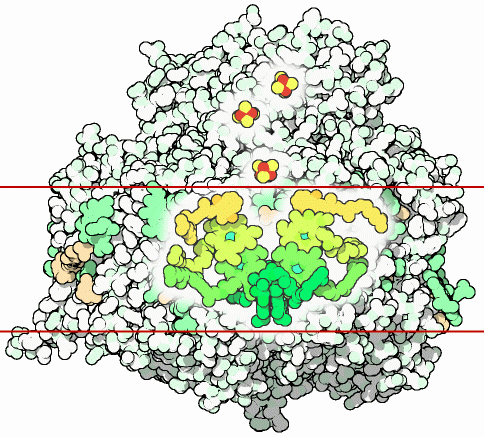

In [19]:
Image(filename='images/xfel_1jb0.png', width=400)
# Reference: http://pdb101.rcsb.org/motm/22

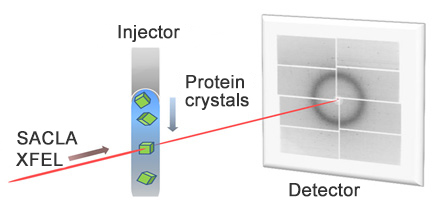

In [20]:
Image(filename='images/xfel.jpg', width=600)
# Reference: http://www.protein.osaka-u.ac.jp/en/achievement-en/papers-en/grease-matrix-as-a-versatile-carrier-of-proteins-for-serial-crystallography

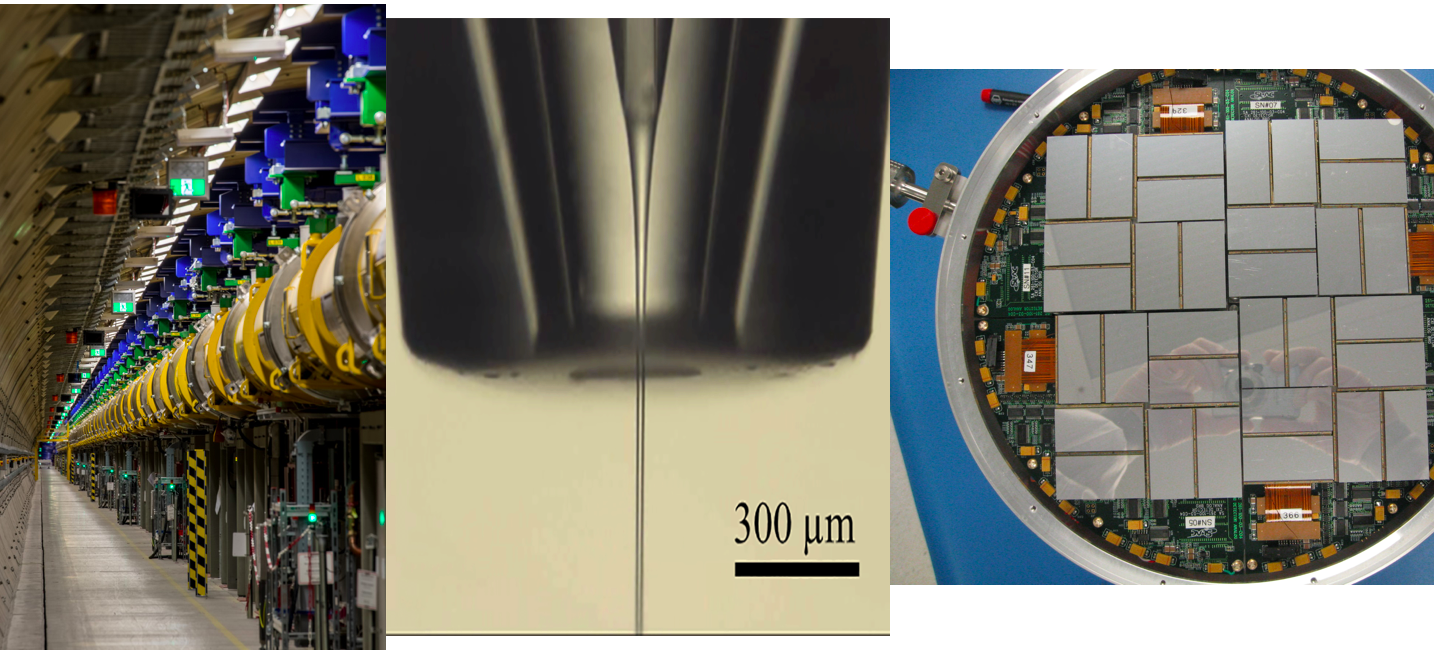

In [22]:
Image(filename='images/xfel_real.png', width=900)

In [23]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

In [24]:
protein = np.genfromtxt('data_visualisation/1dpx_mod.pdb', skip_header=357, skip_footer=190, dtype=None,    \
                         names=['record name','atom_num','atom_type_detailed','residue', \
                                'chainID', 'resSeq', 'coord_x', 'coord_y', 'coord_z',    \
                                'occupancy', 'temperature factor', 'element'])

In [25]:
x = np.arange(-25,25,1)
y = np.arange(0,40,1)
z = np.arange(0,40,1)

X,Y,Z = np.meshgrid(x,y,z)

e_density_vol = np.zeros_like(X)

x = protein['coord_x'][0]
y = protein['coord_y'][0]
z = protein['coord_z'][0]
atom = protein['element'][0].decode("utf-8")


num_atoms = np.max(protein['atom_num'])

for i in range(num_atoms):
    x = protein['coord_x'][i]
    y = protein['coord_y'][i]
    z = protein['coord_z'][i]
    atom = protein['element'][i].decode("utf-8")
    
    if atom == 'C':
        A = 6
    elif atom == 'N':
        A = 7
    elif atom == 'O':
        A = 8
    elif atom == 'S':
        A = 16
    else:
        print("Atom not recognized.")
        break
        
    gaussian_blob = np.exp(-((X-x)**2 + (Y-y)**2 + (Z-z)**2))
    gaussian_blob = (gaussian_blob/np.max(gaussian_blob)) * A
    
    e_density_vol = e_density_vol + gaussian_blob

<IPython.core.display.Javascript object>


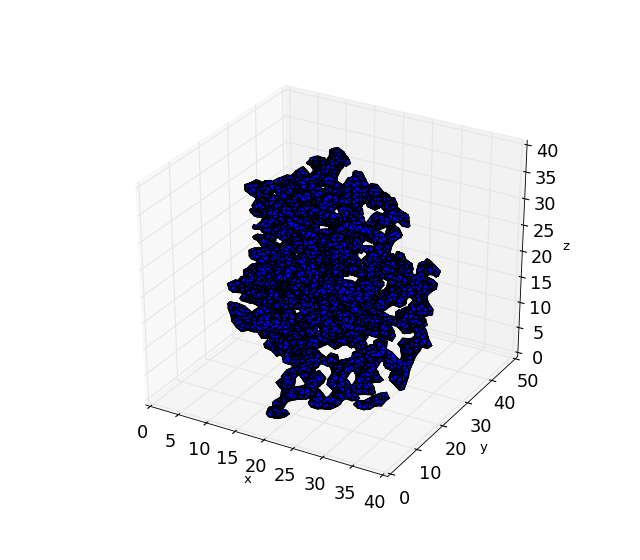

In [27]:
%matplotlib notebook

# Use marching cubes to obtain a surface mesh
isosurface_value = 5
verts, faces = measure.marching_cubes(e_density_vol, isosurface_value)

# Display resulting triangular mesh using Matplotlib
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: "verts[faces]" to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
ax.add_collection3d(mesh)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xlim(0, 40)
ax.set_ylim(0, 50)
ax.set_zlim(0, 40)

plt.show()

In [28]:
%matplotlib inline

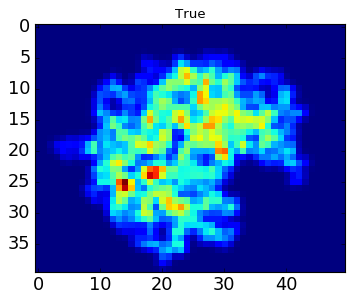

In [29]:
e_density_vol_proj = np.sum(e_density_vol, axis=2)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
im = ax.imshow(e_density_vol_proj, interpolation='nearest')
ax.set_title("True")
plt.show()

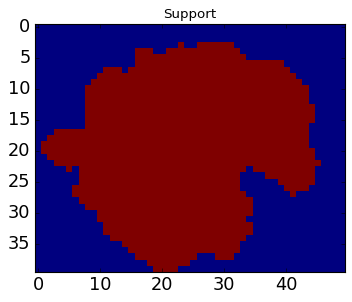

In [30]:
s_temp = e_density_vol_proj > 1e-1

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
im = ax.imshow(s_temp, interpolation='nearest')
ax.set_title("Support")
plt.show()

In [31]:
x_true_temp = e_density_vol_proj * s_temp

In [32]:
Nx, Ny = x_true_temp.shape

In [33]:
# Define the field-of-view
os = 2
Nx_fov = Nx*os
Ny_fov = Ny*os

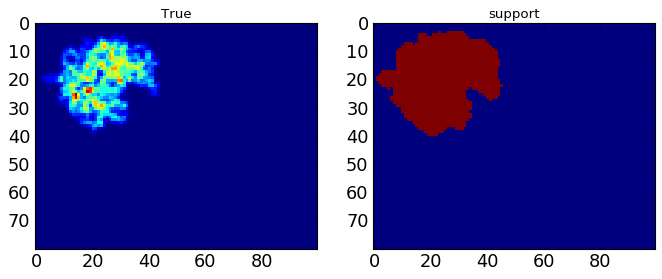

In [34]:
x_true = np.zeros([Nx_fov, Ny_fov])
x_true[0:Nx,0:Ny] = x_true_temp

s = np.zeros([Nx_fov, Ny_fov])
s[0:Nx,0:Ny] = s_temp

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121)
im = ax.imshow(x_true, interpolation='nearest')
ax.set_title("True")

ax = fig.add_subplot(122)
im = ax.imshow(s, interpolation='nearest')
ax.set_title("support")
plt.show()

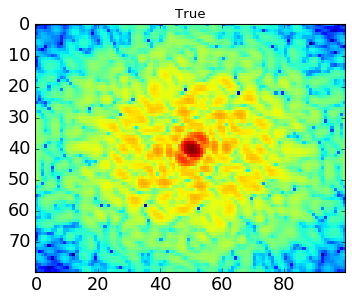

In [35]:
X_true = np.fft.fftn(x_true)
M_true = np.abs(X_true)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
im = ax.imshow(np.log10(np.fft.fftshift(M_true)), interpolation='nearest')
ax.set_title("True")
plt.show()

In [36]:
# Define the projectors
def P_S(x):
    x_new = x*s
    return x_new

def P_M(x):
    X = np.fft.fftn(x)
    X_new = X/(np.abs(X)) * M_true
    x_new = np.fft.ifftn(X_new)
    return x_new

In [37]:
def R_M(x, gamma_M):
    return (1+gamma_M)*P_M(x) - gamma_M*x

def R_S(x, gamma_S):
    return (1+gamma_S)*P_S(x) - gamma_S*x

<IPython.core.display.Javascript object>


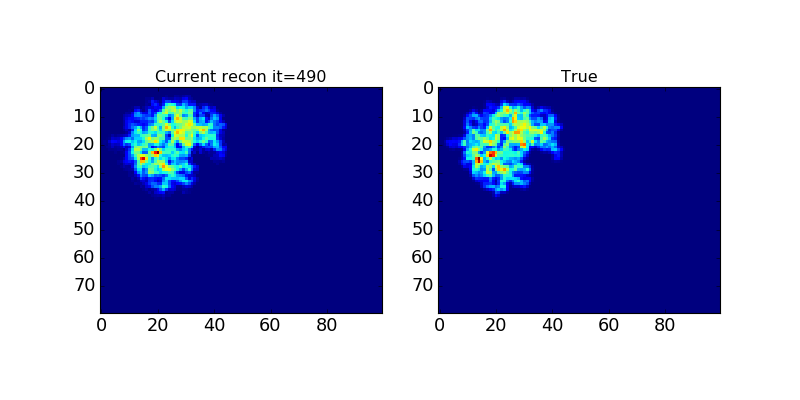

In [39]:
%matplotlib notebook

it_max = 500

beta = 0.9 # Magic number
gamma_M = -1/beta
gamma_S = 1/beta

x = np.random.rand(Nx_fov,Ny_fov)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(122)
im = ax.imshow(np.abs(x_true), interpolation='nearest')
ax.set_title("True")

for it in range(it_max):
    
    # Update rule - the Difference Map
    x_PM = P_M(R_S(x, gamma_S))
    x_PS = P_S(R_M(x, gamma_M))
    x_new = x + beta*(x_PM - x_PS)
    
    x = x_new
    
    x_sol = x_PS
    
    
    if np.mod(it, 10) == 0:
        # Visualize
        ax = fig.add_subplot(121)
        im = ax.imshow(np.abs(x_sol), interpolation='nearest')
        ax.set_title("Current recon it=%d" % it)
        fig.canvas.draw()
        
        time.sleep(0.01)

In [40]:
%matplotlib inline

# More to explore:
* https://en.wikipedia.org/wiki/Hungarian_algorithm

* http://www.anlak.com/2016/05/a-different-kind-of-sudoku-solver.html

* V. Elser, I. Rankenburg and P. Thibault, "Searching with iterated maps", PNAS, 104 (2) 418-423 (2007). http://www.pnas.org/content/104/2/418